In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import numba

from yahist import Hist2D, Hist1D
import uproot_methods
import toolz
from tqdm.auto import tqdm

import utils

In [2]:
utils.set_plotting_style()

gdf = utils.get_geometry_df("/home/users/namin/2019/scouting/repo/geometry/tracker_geometry_data2018.root")

## Make faces and dump

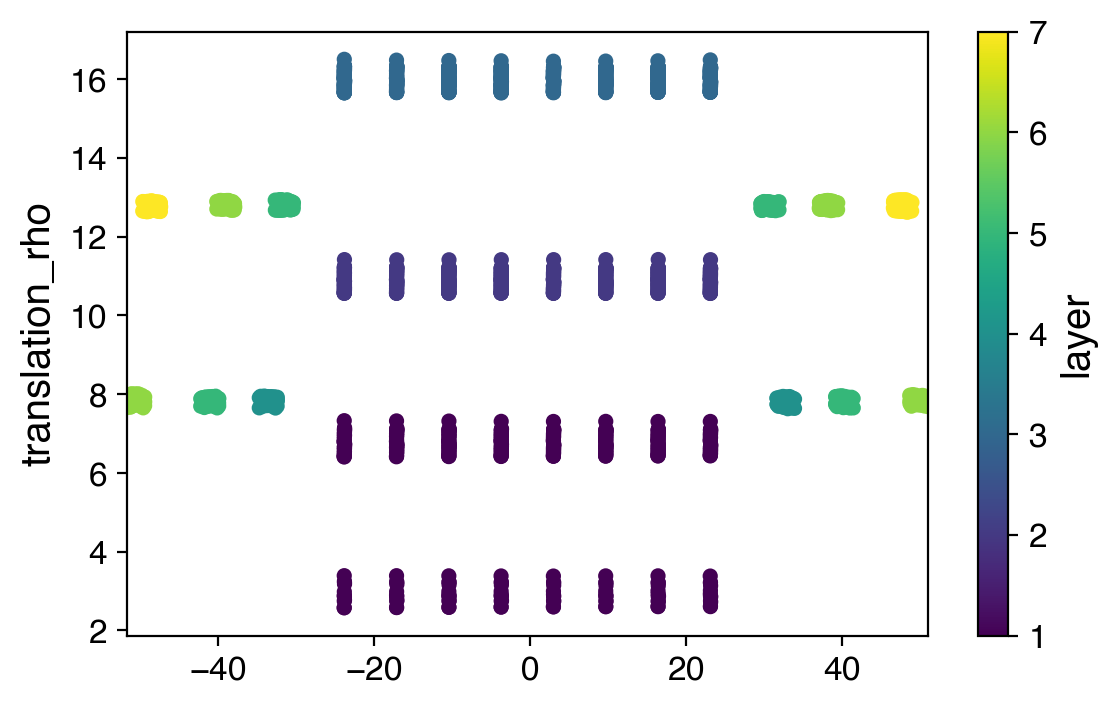

In [3]:
# gdf.query("translation_z>20").plot.scatter(x="translation_z",y="translation_rho")
gdf.plot.scatter(x="translation_z",y="translation_rho",c="layer",cmap="viridis")
# gdf.plot.scatter(x="translation_z",y="translation_rho",c="layer")
# gdf.plot.scatter(x="translation_z",y="translation_rho")#,cmap="viridis")
# gdf.plot.scatter(x="translation_z",y="translation_rho")

# pandas deletes x axis when using cmap kwarg??, so re-enable it
plt.gca().xaxis.tick_bottom()

In [4]:
print(
    2*gdf["shape"].str[1].max(),
    2*gdf["shape"].str[2].max(),
    2*gdf["shape"].str[3].max(),
)

1.6200000047683716 6.480000019073486 0.028999999165534973


In [5]:
%%time
allfaces = []
layernums = []
# for irow,entry in gdf.query("0<translation_z<5").iterrows():
for irow,entry in gdf.iterrows():
    shape = entry["shape"][1:-1].T
    newshape = np.array(shape)
    isendcap = entry["endcap"]

    if isendcap:
        newshape[0] -= 0.03
        newshape[1] -= 0.03
    else:
        newshape[0] -= 0.05
        newshape[1] -= 0.05
    newshape[2] += 0
    shape = newshape

    translation = entry["translation"]
    matrix = entry["matrix"].reshape(3,3)
    faces = []
#     for i in [0,1,2]:
    for i in [2]:  # only the two faces that have the largest area
        for j in [0,1]:
            steps = np.roll(np.array([
                [j,0,0],
                [j,1,0],
                [j,0,1],
                [j,1,1],
            ])*2-1,i)
            face = np.einsum("ij,kj->ik",shape*steps,matrix)+translation
            faces.append(face)
    allfaces.append(np.array(faces))
allfaces = np.array(allfaces)
layernums = gdf["layer"]
gdf["faces"] = [f for f in allfaces]
print(allfaces.shape)
print(layernums.shape)

(1856, 2, 4, 3)
(1856,)
CPU times: user 685 ms, sys: 14 ms, total: 699 ms
Wall time: 690 ms


In [6]:
# for imodule,module in enumerate(allfaces[::-1]):
#     for iface,face in enumerate(module):
#         print(face)
#         a1 = np.cross(face[1]-face[0],face[3]-face[0])
#         a2 = np.cross(face[2]-face[1],face[3]-face[0])
#         print(a1,a2)
#         print(vec_norm(a1))
#         print(vec_norm(a2))
# #         break
#     break

In [7]:
# dump to c++ file

buff = ""
buff += "const unsigned int NMODULES = {};\n".format(len(allfaces))
buff += "const unsigned int NFACES = {};\n".format(2)
buff += "const unsigned int NCORNERS = {};\n".format(4)
buff += "const unsigned int module_layernums[NMODULES] = {{ {} }};\n".format(",".join(map(str,layernums)))
buff += "const TVector3 module_faces[NMODULES][NFACES][NCORNERS] = {\n"

def pointstr(p):
    return "TVector3({:.6f},{:.6f},{:.6f})".format(*p)

mstrs = []
for imodule,module in enumerate(allfaces):
    strs = []
    for face in module:
        strs.append(
            "      {{ {} }}".format(", ".join(list(map(pointstr,face))))
        )
    mstrs.append(
        "    {{\n{}\n    }}".format(",\n".join(strs))
    )
buff += (
    ",\n".join(mstrs)
)
buff += ("\n};")
with open("pixel_module_faces_2018.h","w") as fh:
    fh.write(buff)

## Computation functions

In [8]:
@numba.njit()
def vec_norm(v):
    x = 0.
    for e in v:
        x += e*e
    return x**0.5

@numba.njit()
def unit_vec(v):
    return v/vec_norm(v)

In [9]:
# https://stackoverflow.com/questions/24828653/calculate-if-a-rectangle-is-intersected-by-a-ray-in-c-3d?rq=1

@numba.njit()
def cross_product(v1,v2):
    out = np.array([0.,0.,0.])
    out[0] = v1[1]*v2[2] - v1[2]*v2[1]
    out[1] = v1[2]*v2[0] - v1[0]*v2[2]
    out[2] = v1[0]*v2[1] - v1[1]*v2[0]
    return out


@numba.njit()
def is_inside(vertices, rayorig, raydir):
    v = vertices
    raydirunit = unit_vec(raydir)

    normal = cross_product(v[1]-v[0],v[3]-v[0])
    if np.abs(normal).sum() < 1e-6:
        normal = cross_product(v[2]-v[1],v[3]-v[0])
    normalunit = unit_vec(normal)

    h = np.dot(rayorig - v[0],normalunit)
    dproj = np.dot(raydirunit,-normalunit)
    scale = h/dproj
    if scale < 0: return False
    p = rayorig + raydirunit*scale

    a0 = vec_norm(cross_product(v[0]-p, v[1]-p))
    a1 = vec_norm(cross_product(v[1]-p, v[2]-p))
    a2 = vec_norm(cross_product(v[2]-p, v[3]-p))
    a3 = vec_norm(cross_product(v[3]-p, v[0]-p))
    trec = vec_norm(normal)

    inside = 0.5*(a0+a1+a2+a3) <= trec
    return inside

In [10]:
@numba.njit()
def num_crosses(rayorig, raydir):
    num = 0
    for imodule in range(len(allfaces)):
        module = allfaces[imodule]
        # Don't waste time on modules that are "behind" the trajectory:
        # If going in +z and the module is at lower z, no way we can cross it.
        # Give it a threshold of 7cm because we pick the first point in the module
        # face as a reference point, but modules can be ~6.5cm long in z
        diff = rayorig[2] - module[0][0][2]
        thresh = 7.0
        if raydir[2] > 0:
            if diff > thresh: continue
        else:
            if diff < -thresh: continue
                
        # and again for x coordinate, with threshold of 4cm
        diff = rayorig[0] - module[0][0][0]
        thresh = 3.0
        if raydir[0] > 0:
            if diff > thresh: continue
        else:
            if diff < -thresh: continue
                
        # and again for y (manually unrolled loop over dimension because this is 3-4x faster in numba)
        diff = rayorig[1] - module[0][0][1]
        thresh = 3.0
        if raydir[1] > 0:
            if diff > thresh: continue
        else:
            if diff < -thresh: continue
                
        for iface in range(len(module)):
            if is_inside(
                vertices = module[iface],
                rayorig = rayorig,
                raydir = raydir,
            ):
                num += 1
                break
    return num

def num_crosses_wrapper(x):
    raydir = x
    rayorig = np.array([0.,0,0])
    return num_crosses(rayorig,raydir)

def num_crosses_wrapper_many(xs):
    out = []
    rayorig = np.array([0.,0,0])
    for raydir in xs:
        out.append(num_crosses(rayorig,raydir))
    return out

def num_crosses_wrapper_many_unfold(x):
    out = []
    for px,py,pz,vx,vy,vz in x:
        rayorig = np.array([px,py,pz])
        raydir = np.array([vx,vy,vz])
        out.append(num_crosses(rayorig,raydir))
    return out

In [11]:
%%time
raydir = np.array([1,0.15,0.0])
rayorig = np.array([3.,3,2])

num_crosses(rayorig,raydir)

CPU times: user 4.76 s, sys: 4.25 s, total: 9.01 s
Wall time: 3.84 s


3

In [12]:
%%time
num_crosses(rayorig,raydir)

CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 1.58 ms


3

## Test

In [13]:
import awkward
t = uproot.open("../batch/output_small_mc.root")["Events"]
arrs = t.arrays(["Muon_pt","Muon_eta","Muon_phi","Muon_m",
                 "Muon_vx","Muon_vy","Muon_vz",
                 "Muon_nExpectedPixelHits","Muon_nExpectedPixelHitsCrappy","Muon_nValidPixelHits",
                 "Muon_hit_x","Muon_hit_y","Muon_hit_z","Muon_hit_layer","Muon_hit_barrel","Muon_hit_ndet",
                ],outputtype=dict,namedecode="ascii",entrystop=500)
table = awkward.Table(arrs)
table["p4"] = uproot_methods.TLorentzVectorArray.from_ptetaphim(table["Muon_pt"],table["Muon_eta"],table["Muon_phi"],table["Muon_m"])
table["Muon_px"] = table["p4"].x
table["Muon_py"] = table["p4"].y
table["Muon_pz"] = table["p4"].z
table[2].tolist()

{'Muon_pt': [40.81243133544922, 12.306843757629395],
 'Muon_eta': [-0.33045220375061035, -0.9541273713111877],
 'Muon_phi': [2.2719132900238037, 2.924626111984253],
 'Muon_m': [0.10565999895334244, 0.10565999895334244],
 'Muon_vx': [-1.3328874111175537, -1.3328874111175537],
 'Muon_vy': [1.2239220142364502, 1.2239220142364502],
 'Muon_vz': [-0.8219912648200989, -0.8219912648200989],
 'Muon_nExpectedPixelHits': [3, 4],
 'Muon_nExpectedPixelHitsCrappy': [4, 4],
 'Muon_nValidPixelHits': [4, 3],
 'Muon_hit_x': [[-2.7632532, -10.226532, -15.528834],
  [-2.1418014, -4.658883, -7.314871, -10.613012]],
 'Muon_hit_y': [[1.540247, 3.223917, 4.4539976],
  [2.1817832, 5.1579847, 8.291301, 12.172033]],
 'Muon_hit_z': [[-2.4416537, -10.900578, -16.91862],
  [-1.2438705, -2.5555043, -3.9376905, -5.6514535]],
 'Muon_hit_layer': [[0, 2, 3], [0, 1, 2, 3]],
 'Muon_hit_barrel': [[True, True, True], [True, True, True, True]],
 'Muon_hit_ndet': [[1, 1, 1], [1, 1, 1, 1]],
 'p4': [TLorentzVector(40.812, -0.33

In [29]:
# import ROOT
# ROOT.gROOT.ProcessLine(".L ../batch/data/calculate_pixel.cc")

recalc = []
for vx,vy,vz,px,py,pz in tqdm(zip(
    table["Muon_vx"].flatten(),
    table["Muon_vy"].flatten(),
    table["Muon_vz"].flatten(),
    table["Muon_px"].flatten(),
    table["Muon_py"].flatten(),
    table["Muon_pz"].flatten(),
)):
    nc = num_crosses(np.array([vx,vy,vz]),np.array([px,py,pz]))
#     nc = ROOT.calculate_module_crosses(vx, vy, vz, px, py, pz)
    recalc.append(nc)
recalc = np.array(recalc)
table["recalc"] = awkward.JaggedArray.fromcounts(table["Muon_px"].counts,recalc)

import scipy.stats
print(scipy.stats.pearsonr(table["recalc"].flatten(),table["Muon_nExpectedPixelHitsCrappy"].flatten()))
# scipy.stats.pearsonr(table["recalc"].flatten(),table["Muon_nExpectedPixelHits"].flatten())

h = Hist2D(
    np.c_[table["recalc"].flatten(),table["Muon_nExpectedPixelHitsCrappy"].flatten()],
#     np.c_[table["recalc"].flatten(),table["Muon_nExpectedPixelHits"].flatten()],
#     np.c_[table["Muon_nExpectedPixelHits"].flatten(),table["Muon_nExpectedPixelHitsCrappy"].flatten()],
    bins=np.arange(10)-0.5
)
h.plot(cmap="binary",logz=True)

(0.996351460262506, 0.0)

## Visualization

Text(0, 0.5, 'y (cm)')

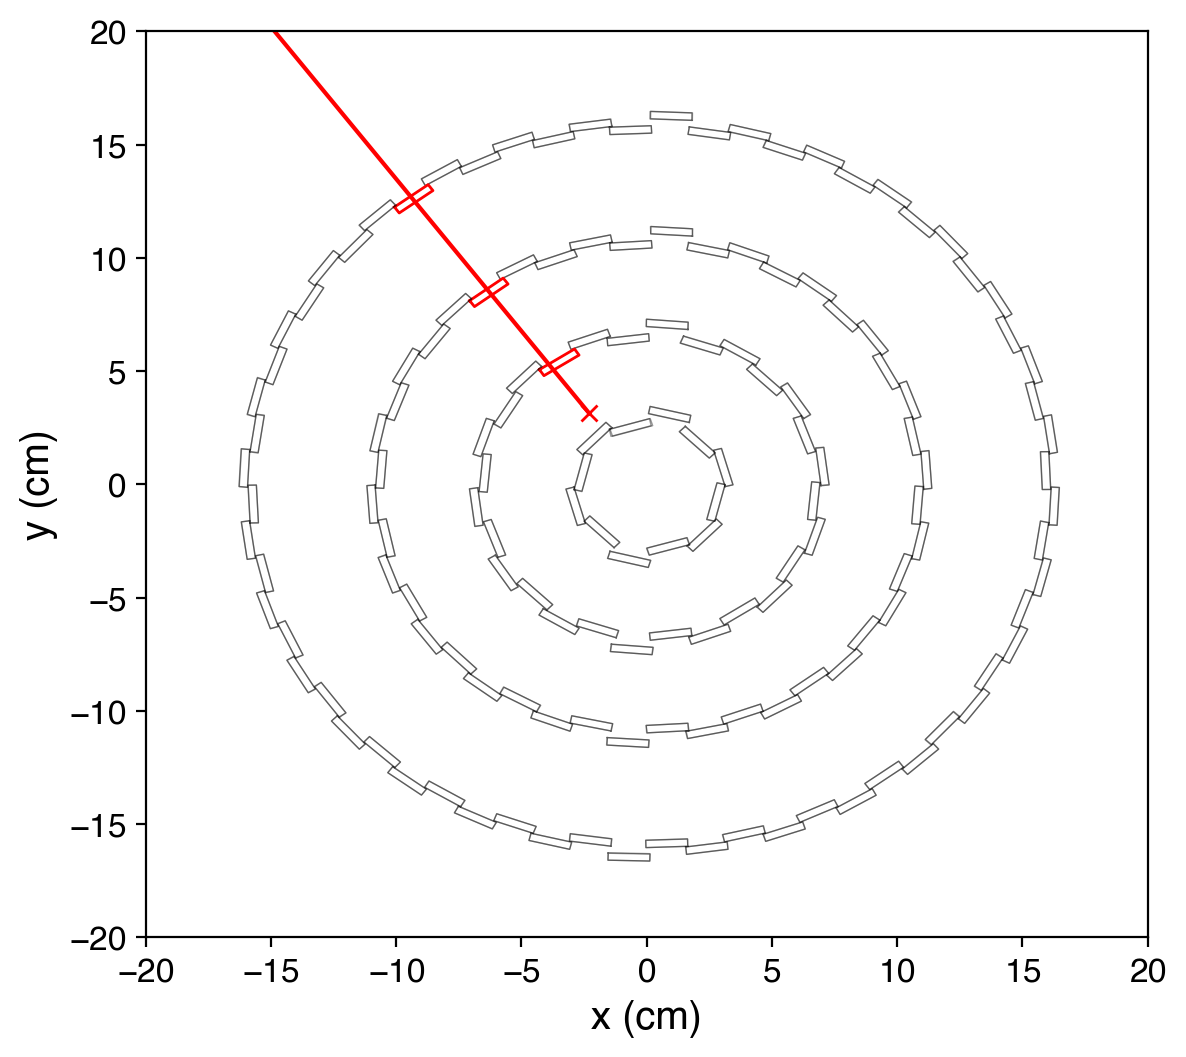

In [134]:
# from ipywidgets import interact
# @interact
# def plot(rx=1.0,ry=1.8,rz=0.0):

rayorig = np.array([3.0,3,2])
raydir = np.array([1,0.15,0.0])

# rayorig = np.array([-3.0,-3,2])
# raydir = np.array([1,4.15,0.0])

idx = 2
# x = testdf.query("valid==3 and numba==2")
x = testdf.query("valid-root==1")
rayorig = x.iloc[idx][["vx","vy","vz"]].values
raydir = x.iloc[idx][["px","py","pz"]].values

fig,ax = plt.subplots(1,1,figsize=(6,6))

step_directions = np.array([
    [0,0,0],[0,0,1],[0,1,0],[0,1,1],
    [1,0,0],[1,0,1],[1,1,0],[1,1,1],
])*2-1


raydir *= 15/ np.linalg.norm(raydir)
for irow,entry in gdf.query("-5<translation_z<5").iterrows():
#         if irow > 250: break
    shape = entry["shape"][1:-1].T
    newshape = np.array(shape)
    newshape[0] += 0.025
    newshape[1] += 0.025
    newshape[2] += 0.15
    shape = newshape
    translation = entry["translation"]
    matrix = entry["matrix"].reshape(3,3)

    points = shape * step_directions
    points = np.einsum("ij,kj->ik",points,matrix) + translation
    points = points[np.array([6,2,1,5,6])]
    ninside = 0
    inside = False
    for face in entry.faces:
        if is_inside(vertices=face,rayorig=rayorig,raydir=raydir):
            ninside += 1
            if ninside >= 2:
                inside = True
                break
                
    if inside:
        ax.plot(points[:,0],points[:,1],color="r",lw=1.0)
    else:
        ax.plot(points[:,0],points[:,1],color="k",lw=0.5,alpha=0.4)

ax.set_xlim([-20,20])
ax.set_ylim([-20,20])

ax.plot(rayorig[0],rayorig[1],color="r",marker="x")
ax.plot([rayorig[0],rayorig[0]+raydir[0]*8],[rayorig[1],rayorig[1]+raydir[1]*8],color="r")


# ax.axis("off")
ax.set_xlabel("x (cm)")
ax.set_ylabel("y (cm)")

Text(0, 0.5, '$\\rho$ (cm)')

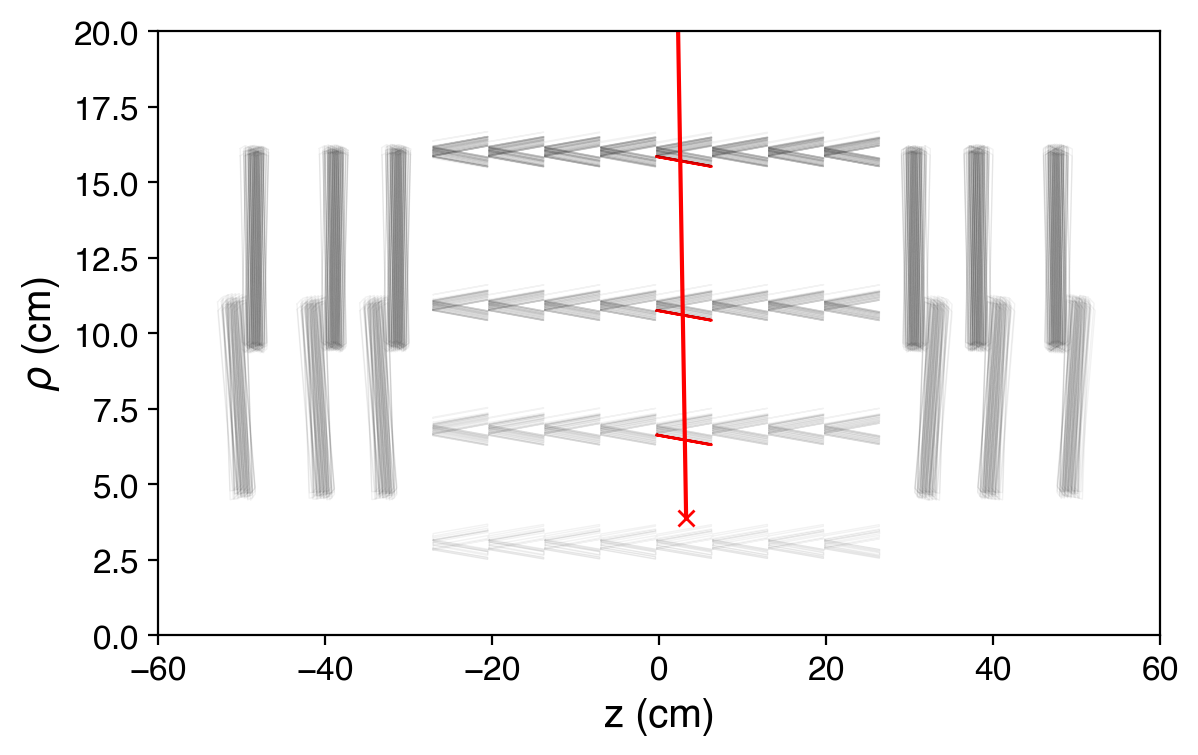

In [135]:
# from ipywidgets import interact
# @interact
# def plot(rx=1.0,ry=1.8,rz=0.0):

rayorig = np.array([3.0,3,2])
raydir = np.array([1,0.15,3.0])

idx = 2
# x = testdf.query("valid==3 and numba==2")
x = testdf.query("valid-root==1")
rayorig = x.iloc[idx][["vx","vy","vz"]].values
raydir = x.iloc[idx][["px","py","pz"]].values

# rayorig = np.array([-3.0,-3,2])
# raydir = np.array([1,4.15,0.0])

fig,ax = plt.subplots(1,1,figsize=(6,4))

step_directions = np.array([
    [0,0,0],[0,0,1],[0,1,0],[0,1,1],
    [1,0,0],[1,0,1],[1,1,0],[1,1,1],
])*2-1

# rayorig = args[sel][1][:3]
# raydir = args[sel][1][3:]

raydir *= 15/ np.linalg.norm(raydir)
# for irow,entry in gdf.query("0<translation_z<5").iterrows():
for irow,entry in gdf.iterrows():
#         if irow > 250: break
    shape = entry["shape"][1:-1].T
    newshape = np.array(shape)
    newshape[0] += 0.025
    newshape[1] += 0.025
    newshape[2] += 0.15
    shape = newshape
    translation = entry["translation"]
    matrix = entry["matrix"].reshape(3,3)

    points = shape * step_directions
    points = np.einsum("ij,kj->ik",points,matrix) + translation
    points = points[np.array([6,2,1,5,6])]
    ninside = 0
    inside = False
    for face in entry.faces:
        if is_inside(vertices=face,rayorig=rayorig,raydir=raydir):
            ninside += 1
            if ninside >= 2:
                inside = True
                break
#     if inside:
#         print(irow)
#         print(entry.faces)
#         print(rayorig)
#         print(raydir)
    rho = np.hypot(points[:,0],points[:,1])
    if inside:
        ax.plot(points[:,2],rho,color="r",lw=1.0)
    else:
        ax.plot(points[:,2],rho,color="k",lw=0.5,alpha=0.05)

ax.set_xlim([-60,60])
ax.set_ylim([0,20])

raydirrho = np.hypot(raydir[0]-rayorig[0],raydir[1]-rayorig[1])
rayorigrho = np.hypot(rayorig[0],rayorig[1])
ax.plot(rayorig[2],rayorigrho,color="r",marker="x")
ax.plot([rayorig[2],rayorig[2]+raydir[2]*8/2**0.5],[rayorigrho,rayorigrho+raydirrho*8],color="r")


# ax.axis("off")
ax.set_xlabel("z (cm)")
ax.set_ylabel(r"$\rho$ (cm)")

## Tuning overlaps

In [13]:
df_data = pd.read_pickle("data/df_data.pkl")
df_mc = pd.read_pickle("data/df_mc.pkl")

In [14]:
import ROOT
ROOT.gROOT.ProcessLine(".L ../batch/data/calculate_pixel.cc")

Welcome to JupyROOT 6.18/00


0

In [127]:
# df = df_mc.query(
df = df_data.query(
    " (dimuon_mass>0) "
#     " and (18 < Muon1_pt < 40) "
    " and (abs(Muon1_eta) < 0.3) "
#     " and (abs(DV_z) < 15) "
    " and (3.5 < DV_rho < 5.5) "
    
    # FIXME for data
    " and dimuon_mass>5 "
    " and Muon1_pt>10"
)
df

,nDV,nDV_good,nJet,nPV,nPVM,nMuon,nMuon_good,nGenPart,nGenMuon,pass_skim,...,DV_redchi2,DV_xyErrorMax,Muon1_redchi2,Muon2_redchi2,Muon1_adqpt,Muon2_adqpt,maxabsdxy,minabsdxy,maxdxy,mindxy
1726,1,1,0,12,3,2,2,0,0,True,...,3.498729,0.003296,0.715747,1.159895,0.009440,0.014202,0.022833,0.003488,0.003488,-0.022833
4198,1,1,0,0,4,2,2,0,0,True,...,6.249588,0.004657,0.808253,0.748145,0.013873,0.008817,0.015479,0.011680,0.015479,-0.011680
10707,1,1,0,0,5,2,2,0,0,True,...,0.084847,0.005676,1.096917,1.839893,0.007495,0.009951,0.016452,0.013087,0.016452,-0.013087
13386,1,1,0,16,4,2,2,0,0,True,...,0.011242,0.002433,0.529462,1.018790,0.010883,0.014501,0.010484,0.002514,0.002514,-0.010484


In [113]:
x = testdf.query("valid==3 and numba==1")
x


,root,numba,valid,vx,vy,vz,px,py,pz,vxerr,vyerr,vzerr


In [128]:
data = []
for irow,row in tqdm(df.iterrows()):
    vxerr = row["DV_xError"]
    vyerr = row["DV_yError"]
    vzerr = row["DV_zError"]
    vx = row["DV_x"]
    vy = row["DV_y"]
    vz = row["DV_z"]
    pt = row["Muon1_pt"]
    eta = row["Muon1_eta"]
    phi = row["Muon1_phi"]
    mass = row["Muon1_m"]
    vec = uproot_methods.TLorentzVector.from_ptetaphim(pt,eta,phi,mass)
    px, py, pz = vec.x, vec.y, vec.z
    raydir = np.array([px,py,pz])
    rayorig = np.array([vx,vy,vz])
    crosses_valid = row["Muon1_nValidPixelHits"]
    
    crosses_root = ROOT.calculate_module_crosses(vx, vy, vz, px, py, pz)
    crosses_numba = num_crosses(rayorig,raydir)
    data.append(dict(root=crosses_root, numba=crosses_numba, valid=crosses_valid,vx=vx,vy=vy,vz=vz,px=px,py=py,pz=pz,vxerr=vxerr,vyerr=vyerr,vzerr=vzerr))
testdf = pd.DataFrame(data)

In [129]:
testdf

,root,numba,valid,vx,vy,vz,px,py,pz,vxerr,vyerr,vzerr
0,3,3,4,0.252255,4.025568,-2.398480,0.928537,23.705764,-3.131896,0.000775,0.003296,0.003332
1,3,3,3,-0.531847,3.681009,0.106163,-2.126002,12.460000,-3.772889,0.001355,0.004657,0.001863
2,2,4,3,1.820946,4.040062,-1.893374,4.346642,10.236785,-0.879159,0.002530,0.005676,0.003605
3,3,3,4,-2.299575,3.146833,3.247201,-9.694239,13.018403,-1.011747,0.001885,0.002433,0.002662


In [115]:
# # bins = np.arange(8)-0.5
# bins = np.arange(10)-0.5
# fig, ax = plt.subplots()
# Hist1D(testdf["root"],bins=bins).plot(label="root",histtype="step",ax=ax)
# Hist1D(testdf["numba"],bins=bins).plot(label="numba",histtype="step",ax=ax)
# Hist1D(testdf["valid"],bins=bins).plot(label="valid",histtype="step",ax=ax)
# ax.legend()

# fig, ax = plt.subplots()
# bins = np.arange(10)-4.5
# Hist1D(testdf.eval("valid-root"),bins=bins).plot(label="valid-root",histtype="step",ax=ax)
# Hist1D(testdf.eval("valid-numba"),bins=bins).plot(label="valid-numba",histtype="step",ax=ax)
# ax.legend()

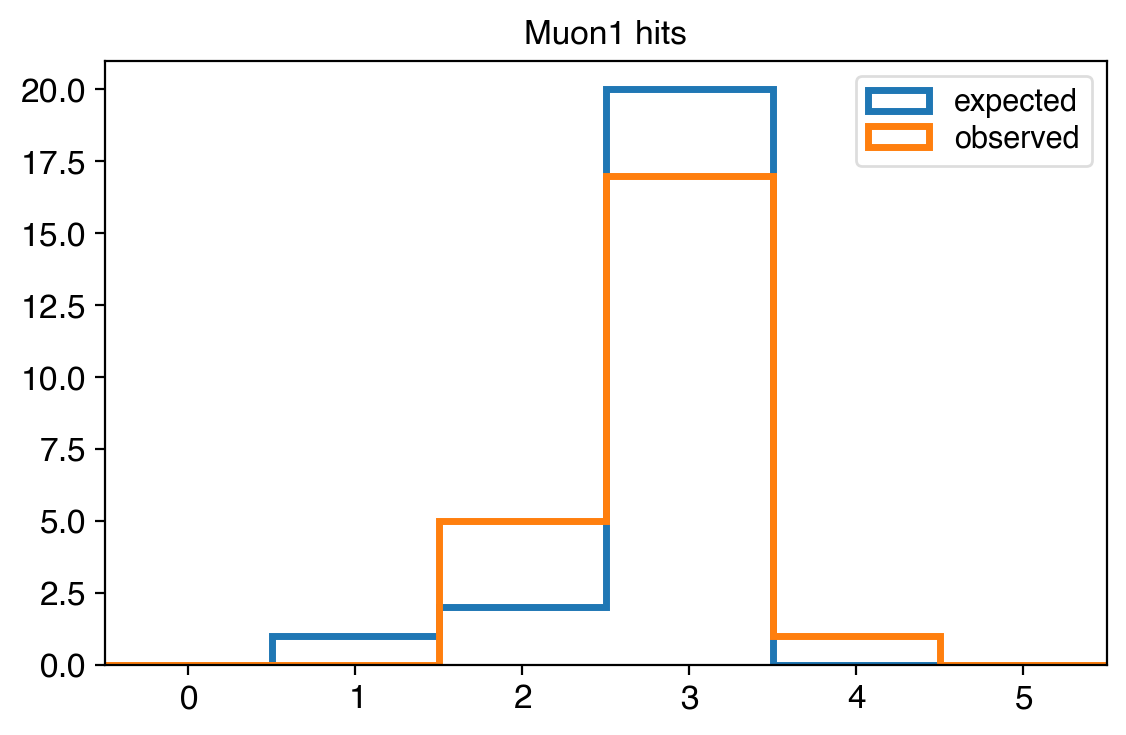

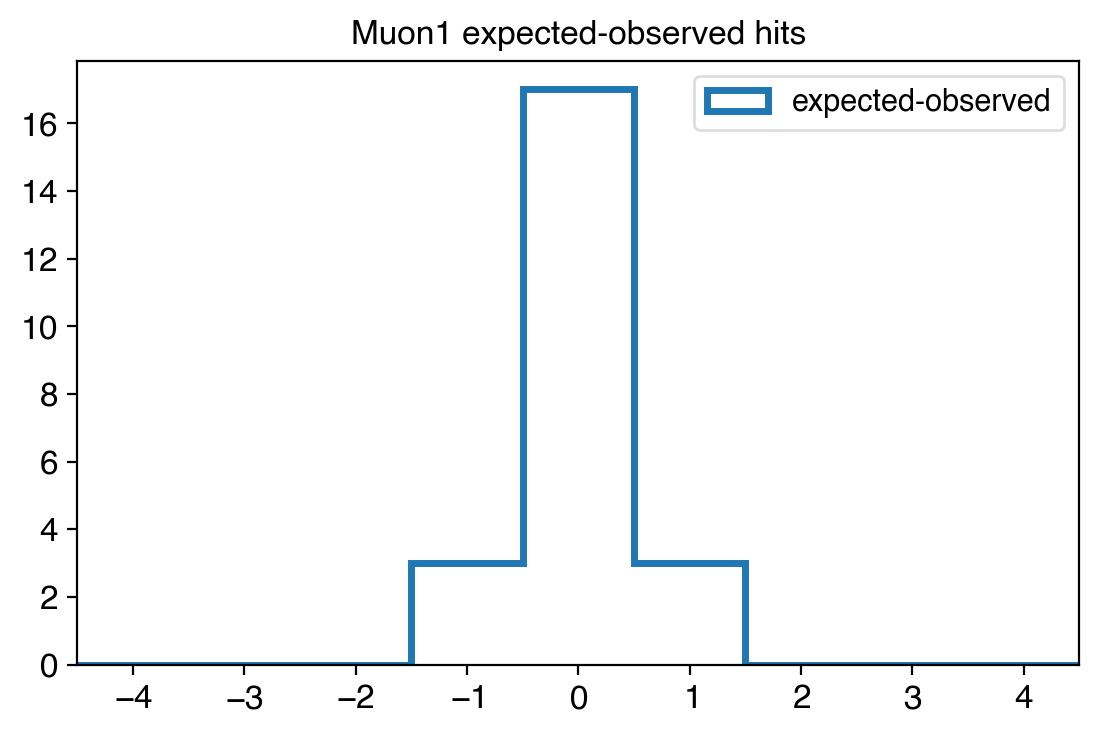

In [116]:
fig, ax = plt.subplots()
bins = np.arange(7)-0.5
Hist1D(testdf["root"],bins=bins).plot(label="expected",histtype="step",ax=ax,lw=2.5)
Hist1D(testdf["valid"],bins=bins).plot(label="observed",histtype="step",ax=ax,lw=2.5)
ax.set_title("Muon1 hits")
ax.legend()

fig, ax = plt.subplots()
bins = np.arange(10)-4.5
Hist1D(testdf.eval("root-valid"),bins=bins).plot(label="expected-observed",histtype="step",ax=ax,lw=2.5)
ax.set_title("Muon1 expected-observed hits")
ax.legend()

## Comparison plots for expected pixel hits

In [279]:
from dask import delayed
from dask.distributed import Client
client = Client("uaf-10.t2.ucsd.edu:50123")
client

Client Scheduler: tcp://uaf-10.t2.ucsd.edu:50123 Dashboard: http://uaf-10.t2.ucsd.edu:8787/status,Cluster Workers: 20 Cores: 20 Memory: 100.00 GB


In [280]:
etabins = np.linspace(-2.4,2.4,251)
phibins = np.linspace(-np.pi,np.pi,251)

etabincenters = 0.5*(etabins[:-1]+etabins[1:])
phibincenters = 0.5*(phibins[:-1]+phibins[1:])

etas = np.tile(etabincenters, len(phibincenters))
phis = np.repeat(phibincenters, len(etabincenters))

p4s = uproot_methods.TLorentzVectorArray.from_ptetaphim(
    np.ones(len(etas))*50.,etas,phis,np.zeros(len(etas))
)
vecs = p4s.p3

args = np.c_[vecs.x,vecs.y,vecs.z]
results = sum(
    client.gather(
        client.map(
            num_crosses_wrapper_many,list(toolz.partition_all(500,args))
        )
    )
,[])

h = Hist2D(np.c_[etas,phis], bins=[etabins,phibins], weights=np.array(results))

Text(0, 0.5, '$\\phi$')

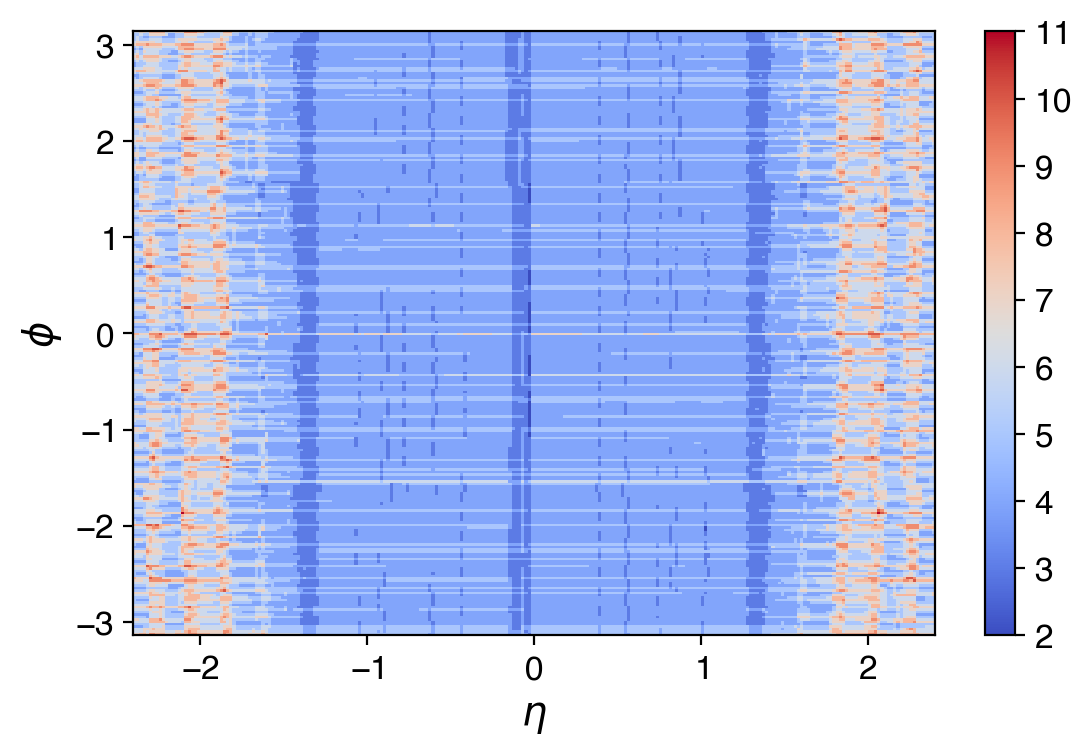

In [281]:
fig, ax = plt.subplots()
h.plot(ax=ax,cmap="coolwarm")
ax.set_xlabel(r"$\eta$")
ax.set_ylabel(r"$\phi$")

Text(0, 0.5, '$\\phi$')

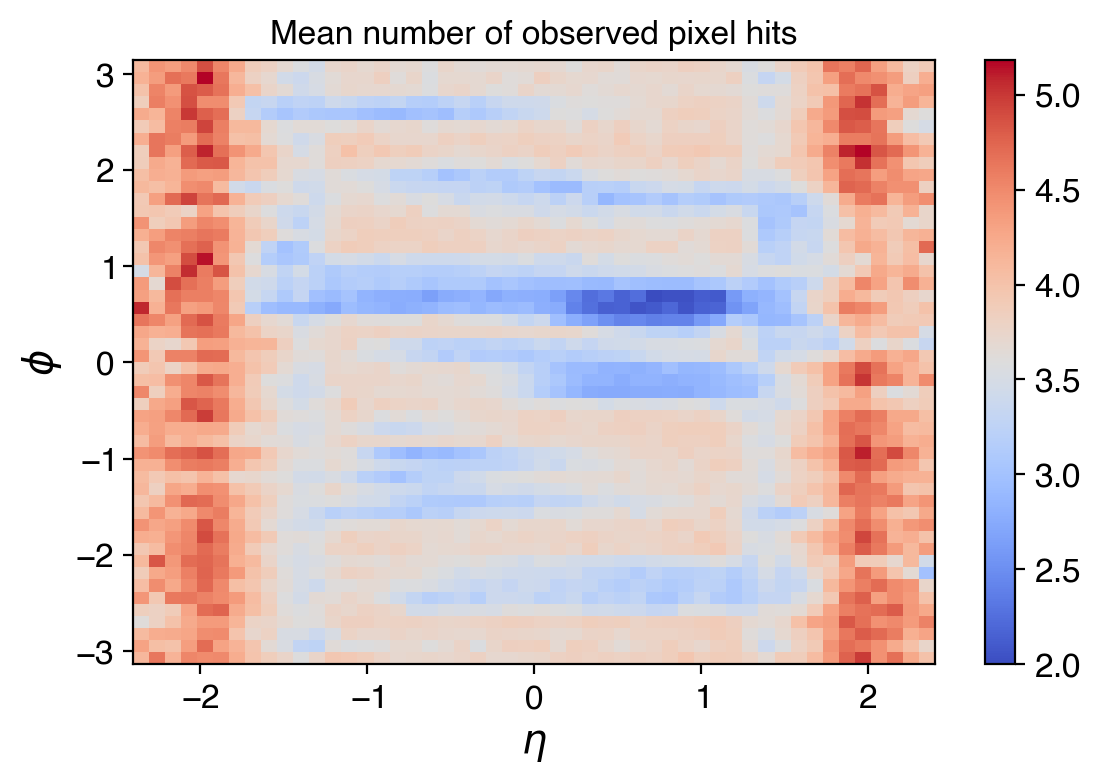

In [337]:
df = df_data
# df = df_mc
hnum = Hist2D(np.c_[df["Muon1_eta"],df["Muon1_phi"]], bins=[np.linspace(-2.4,2.4,51),np.linspace(-np.pi,np.pi,51)], weights=df["Muon1_nValidPixelHits"])
hden = Hist2D(np.c_[df["Muon1_eta"],df["Muon1_phi"]], bins=[np.linspace(-2.4,2.4,51),np.linspace(-np.pi,np.pi,51)])
fig, ax = plt.subplots()
(hnum/hden).plot(ax=ax,cmap="coolwarm")
ax.set_title("Mean number of observed pixel hits")
ax.set_xlabel(r"$\eta$")
ax.set_ylabel(r"$\phi$")

In [311]:
# df = df_data.head(30000)
df = df_mc.head(30000)

In [312]:
dvx = df["DV_x"]#-df["BS_x"]
dvy = df["DV_y"]#-df["BS_y"]
dvz = df["DV_z"]#-df["BS_z"]

mu1x = df.vec.mu1.x
mu1y = df.vec.mu1.y
mu1z = df.vec.mu1.z

# args = np.c_[dvx,dvy,dvz,mu1x,mu1y,mu1z]
args = np.c_[dvx,dvy,dvz,mu1x,mu1y,mu1z]
# args

ncrosses = np.array(sum(
    client.gather(
        client.map(
            num_crosses_wrapper_many_unfold,list(toolz.partition_all(500,args))
        )
    )
,[]))

(df["Muon1_nValidPixelHits"]==ncrosses).mean()

0.554

In [313]:
sel = (
    (np.abs(df["Muon1_eta"])<0.2)
 & (np.abs(df["DV_rho"])>8.)
 & (np.abs(df["DV_z"])<2.)
#  (np.abs(df["DV_rho"])>10.)
)
(df["Muon1_nValidPixelHits"]==ncrosses)[sel].mean()

0.8171641791044776

Text(0, 0.5, 'expected')

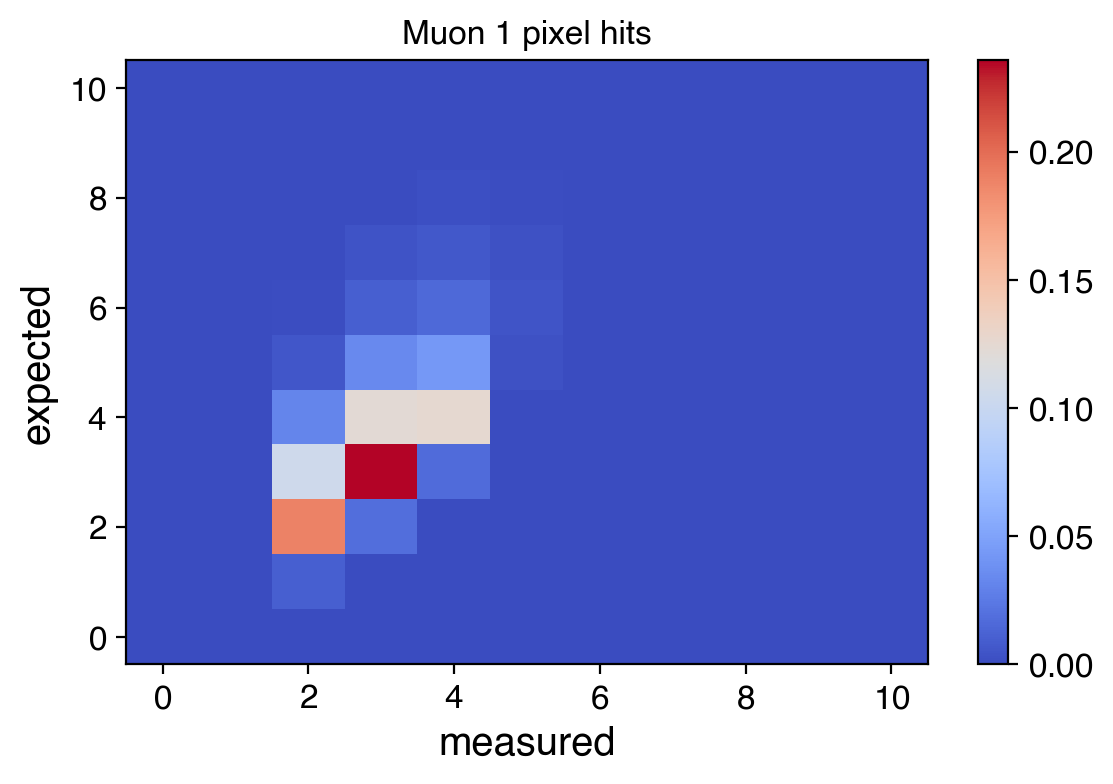

In [321]:
fig, ax = plt.subplots()
Hist2D(np.c_[df["Muon1_nValidPixelHits"],ncrosses],bins=np.arange(12)-0.5).normalize().plot(ax=ax,cmap="coolwarm")
# Hist2D(np.c_[df["Muon1_nValidPixelHits"][sel],ncrosses[sel]],bins=np.arange(12)-0.5).plot(ax=ax,cmap="cividis")
ax.set_title("Muon 1 pixel hits")
ax.set_xlabel("measured")
ax.set_ylabel("expected")
# ncrosses

Text(0.5, 1.0, 'Muon 1 expected - measured')

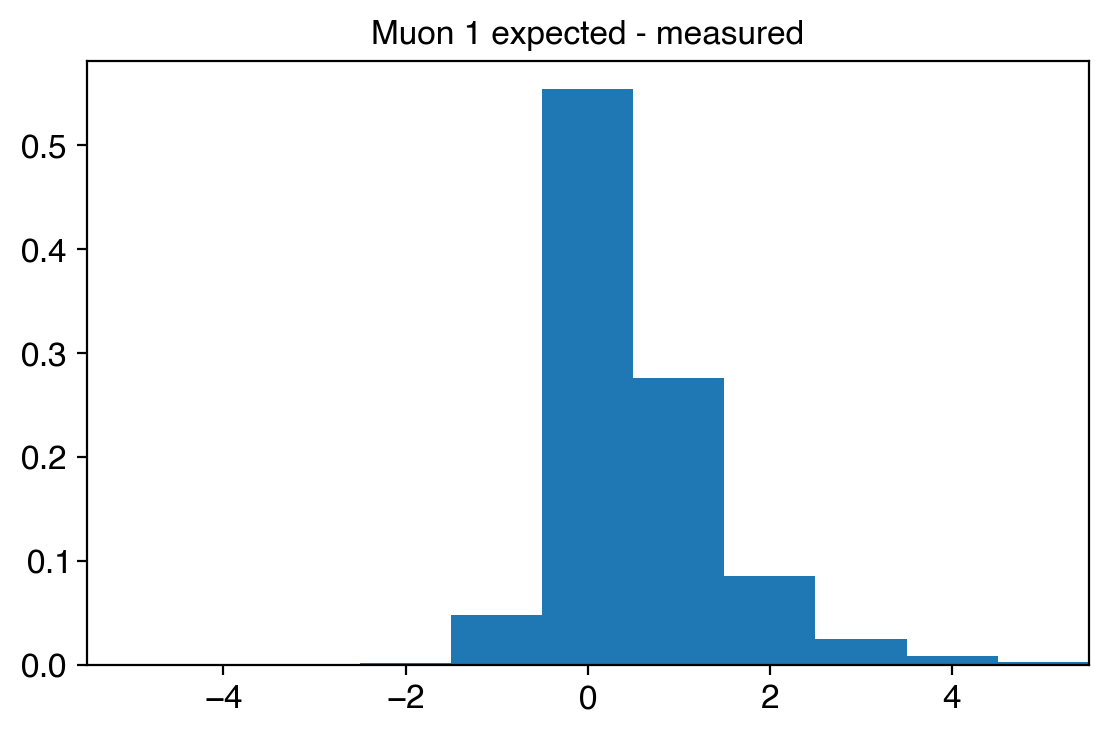

In [318]:
fig, ax = plt.subplots()
Hist1D(ncrosses-df["Muon1_nValidPixelHits"],bins=np.arange(12)-5.5).normalize().plot(ax=ax)
ax.set_title("Muon 1 expected - measured")

## Inside pixel modules?

In [401]:
%%time
vshape = []
vtranslation = []
vmatrix = []
for irow,entry in gdf.iterrows():
    shape = entry["shape"][1:-1].T
    newshape = np.array(shape)
    newshape[0] += 0.025
    newshape[1] += 0.025
    newshape[2] += 0.15
    shape = newshape
    translation = entry["translation"]
    matrix = entry["matrix"].reshape(3,3)
    vshape.append(shape)
    vtranslation.append(translation)
    vmatrix.append(matrix.T)

CPU times: user 399 ms, sys: 13 ms, total: 412 ms
Wall time: 419 ms


In [492]:
# to check for containment of a point inside a pixel module
# we transform the point with the inverse transformation of the pixel module.
# The module is then a box around the origin with half-widths given by `shape`
# We check that each coordinate of the point is within the half width
# --> (np.abs(np.dot(matrix, point-translation))<shape).sum() == 3
# below is a more vanilla implementation with hardcoded matrix multiplication
    
@numba.njit()
def f(point, flatmatrix, translation, shape):
    shifted = np.array([0.,0.,0.])
    for i in range(3):
        shifted[i] = point[i]-translation[i]
    for i in range(3):
        if abs(flatmatrix[3*i]*shifted[0] + flatmatrix[3*i+1]*shifted[1] + flatmatrix[3*i+2]*shifted[2]) > shape[i]: return False
    return True

(-15.0, 15.0)

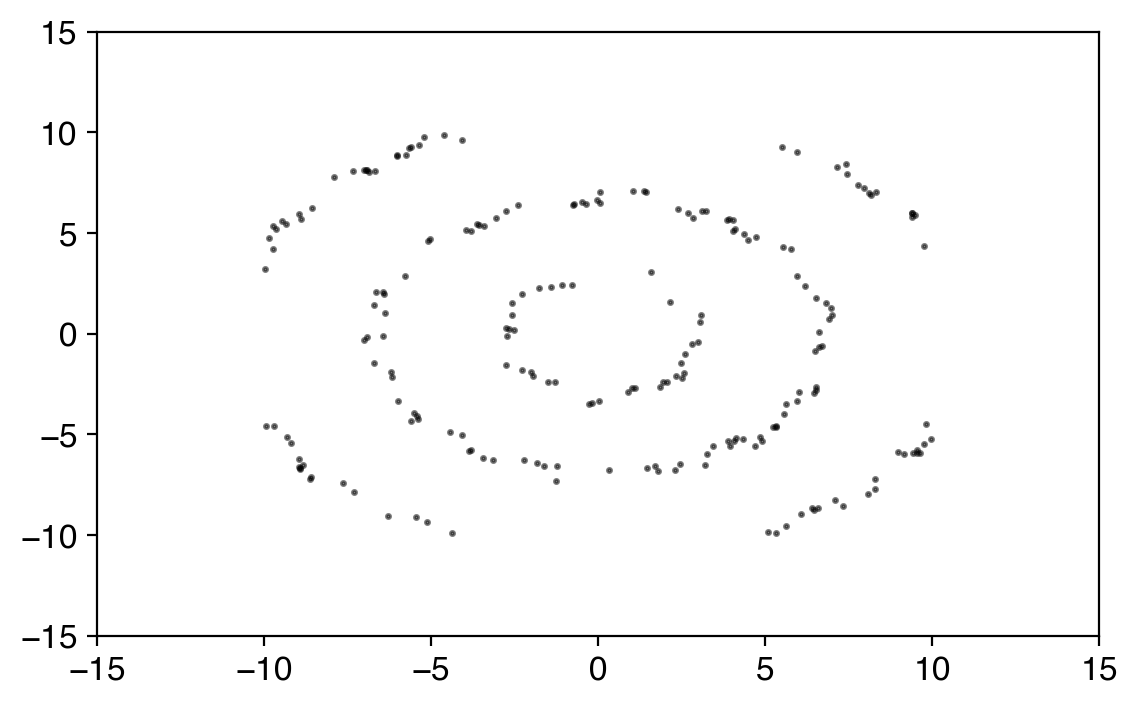

In [517]:
fig, ax = plt.subplots()
for _ in tqdm(range(2500)):
    point = np.array([np.random.uniform(-10,10), np.random.uniform(-10,10), 2.0])
#     point = np.array([np.random.uniform(6.0,7.8), np.random.uniform(-1.5,3.8), 2.0])

    inside = False
    for imodule, (shape, translation, matrix) in enumerate(zip(vshape, vtranslation, vmatrix)):
        check = f(point, matrix.flatten(), translation, shape)
        if check:
            inside = True
            break
    if inside:
        ax.plot(point[0],point[1], marker="o", color="k", ms=1.5, alpha=0.5)
    
ax.set_xlim(-15.,15.)
ax.set_ylim(-15.,15.)

In [510]:
# dump to c++ file

buff = ""
buff += "// First 9 elements are rotation matrix, then 3 for translation, then 3 for shape\n"
buff += "// Test if a point is contained in a module with\n"
buff += """
/*
def f(point, arr):
    shifted = np.array([0.,0.,0.])
    for i in range(3):
        shifted[0] = point[0]-arr[i+9]
    for i in range(3):
        if abs(arr[3*i]*shifted[0] + arr[3*i+1]*shifted[1] + arr[3*i+2]*shifted[2]) > arr[i+12]: return False
    return True
*/\n
"""
buff += "const unsigned int NMODULES = {};\n".format(len(allfaces))
buff += "float module_volumes[NMODULES][15] = {\n"

mstrs = []
for imodule, (shape, translation, matrix) in enumerate(zip(vshape, vtranslation, vmatrix)):
    mstrs.append(("  {{ "
     "{:.7f},{:.7f},{:.7f},{:.7f},{:.7f},{:.7f},{:.7f},{:.7f},{:.7f},"
     "{:.7f},{:.7f},{:.7f},"
     "{:.7f},{:.7f},{:.7f} "
     "}}").format(*matrix.flatten(), *translation, *shape))
buff += (
    ",\n".join(mstrs)
)
buff += ("\n};")
with open("pixel_module_volumes_2018.h","w") as fh:
    fh.write(buff)

## Misc

In [147]:
bfield_in_tesla = 3.8
bfield_in_invgev = 1. / (bfield_in_tesla * 2.99792458e-3)
def bending_radius(pt):
    # radius of curvature in b field, in cm
    return pt * bfield_in_invgev
def longitudinal_bending_correction(r, pt):
    # distance between straight line propagation and helix, at radius r (cm)
    br = bending_radius(pt)
    return (r/24.) * (r/br)**2

In [160]:
longitudinal_bending_correction(10, 5) * 1e4

2.1630041301599414

In [159]:
gdf.query("abs(translation_z)<5")["shape"]

entry
3       [2.0, 0.81, 3.24, 0.01425, 0.0]
4       [2.0, 0.81, 3.24, 0.01425, 0.0]
11      [2.0, 0.81, 3.24, 0.01425, 0.0]
12      [2.0, 0.81, 3.24, 0.01425, 0.0]
19      [2.0, 0.81, 3.24, 0.01425, 0.0]
                     ...               
1164    [2.0, 0.81, 3.24, 0.01425, 0.0]
1171    [2.0, 0.81, 3.24, 0.01425, 0.0]
1172    [2.0, 0.81, 3.24, 0.01425, 0.0]
1179    [2.0, 0.81, 3.24, 0.01425, 0.0]
1180    [2.0, 0.81, 3.24, 0.01425, 0.0]
Name: shape, Length: 296, dtype: object

In [426]:
import sys
sys.path.insert(len(sys.path), "../propagation/MilliqanSim/millisim/")
from Environment import Environment
from Integrator import Integrator

environment = Environment(
        mat_setup="none",
        bfield="cms",
        bfield_file="../propagation/MilliqanSim/bfield/bfield_coarse.pkl",
        )

mass = 105.
Q = -1.0
B = 3.8
integrator = Integrator(
        environ=environment,
        m=mass,
        Q=Q,
        dt=0.05,
        nsteps=100,
#         cutoff_dist=1.0,
        cutoff_dist=0.1,
        cutoff_axis="r",
        )

In [427]:

def get_trajectory(
    vx, vy, vz, # initial position in meters
    px, py, pz, # momentum in GeV
    times = np.linspace(0, 2.0, 100.), # times (in ns) to evaluate position
    mass = 105., # particle mass in MeV
    Q = -1., # particle charge in units of |electron charge|
    B = 3.8, # magnetic field in Tesla
):
    # convert momentum to MeV
    x0 = np.array([vx, vy, vz, 1e3*px, 1e3*py, 1e3*pz])
    
    v0 = x0[:3]
    p0 = x0[3:]
    
    # momentum magnitudes, and energies
    P = np.linalg.norm(p0)
    Pxy = np.linalg.norm(p0[:2])
    E = np.sqrt(P**2 + mass**2)
    
    # velocities (relativistic)
    vx = p0[0]/E * c
    vy = p0[1]/E * c
    vz = p0[2]/E * c
    vxy = np.hypot(vx,vy)
    
    # larmor radius/angular frequency
    R = Pxy/(300.*Q*B)
    w = vxy/R
    
    # columns of x,y,z positions over time
    return np.c_[
        v0[0] + (vy/w)*( 1 - np.cos(w*times)) + (vx/w)*np.sin(w*times),
        v0[1] + (vx/w)*(-1 + np.cos(w*times)) + (vy/w)*np.sin(w*times),
        v0[2] + vz*times,
    ]



In [429]:
# in meters
vx = 0.
vy = 0.
vz = 0.

# in GeV
px = 3.0
py = 1.0
pz = 3.5

# px = 0.1
# py = 0.0
# pz = 0.5

x0 = np.array([vx, vy, vz, 1e3*px, 1e3*py, 1e3*pz])
traj,tvec = integrator.propagate(x0)

(-0.12, 0.12)

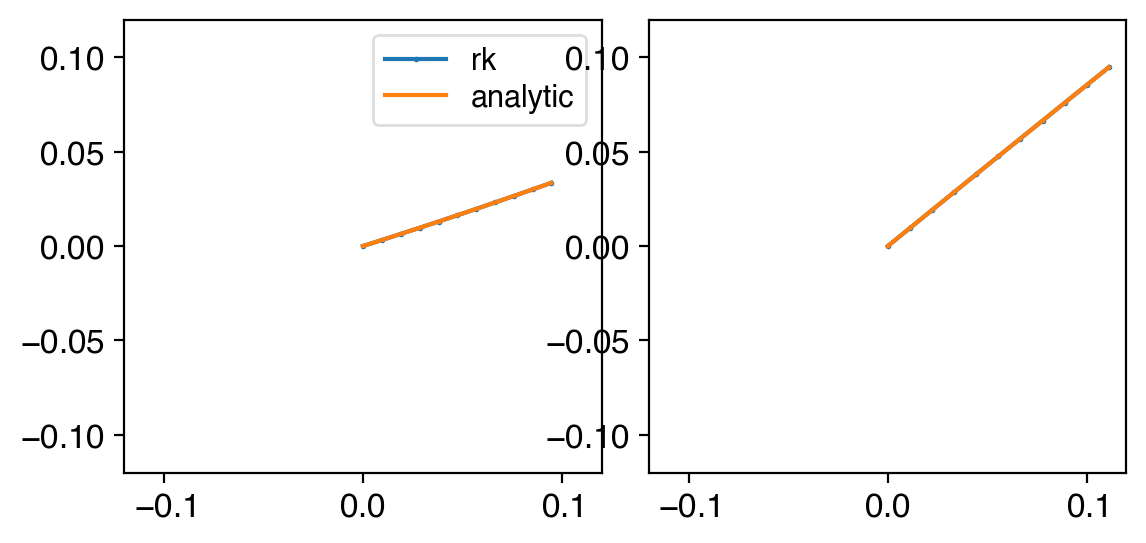

In [430]:
pred = get_trajectory(vx, vy, vz, px, py, pz, times=tvec)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(6,3))
ax = ax1
ax.plot(traj[0],traj[1],marker="o",label="rk",ms=1)
ax.plot(pred[:,0],pred[:,1],marker="+",label="analytic",ms=1)
ax.set_xlim([-0.12,0.12])
ax.set_ylim([-0.12,0.12])
ax.legend()

ax = ax2
ax.plot(traj[2],traj[0],marker="o",label="rk",ms=1)
ax.plot(pred[:,2],pred[:,0],marker="+",label="analytic",ms=1)
ax.set_xlim([-0.12,0.12])
ax.set_ylim([-0.12,0.12])

In [243]:
P = np.linalg.norm(p0)
Pxy = np.hypot(px,py)
E = np.sqrt(P**2 + mass**2)
R = Pxy/(300.*Q*B)
vxy = Pxy/E * c
T = 2*np.pi*R/vxy
w = 2*np.pi/T
predx = v0[0] + R*np.sin(w*tvec)
predy = v0[1] + R*np.cos(w*tvec)
predz = v0[2] + p0[2]/P*c*tvec
predx

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(6,3))
ax = ax1
ax.plot(traj[0],traj[1],marker="o",label="rk",ms=3)
ax.plot(predx,predy,marker="+",label="analytic")
ax.set_xlim([-0.12,0.12])
ax.set_ylim([-0.12,0.12])
ax.legend()

ax = ax2
ax.plot(traj[2],traj[0],marker="o",label="rk",ms=3)
ax.plot(predz,predx,marker="+",label="analytic")
ax.set_xlim([-0.12,0.12])
ax.set_ylim([-0.12,0.12])

array([0.       , 0.0059958, 0.0119916, 0.0179874, 0.0239832, 0.029979 ,
       0.0359748, 0.0419706, 0.0479664, 0.0539622, 0.059958 , 0.0659538,
       0.0719496, 0.0779454, 0.0839412, 0.089937 , 0.0959328, 0.1019286,
       0.1079244])

(-0.15, 0.15)

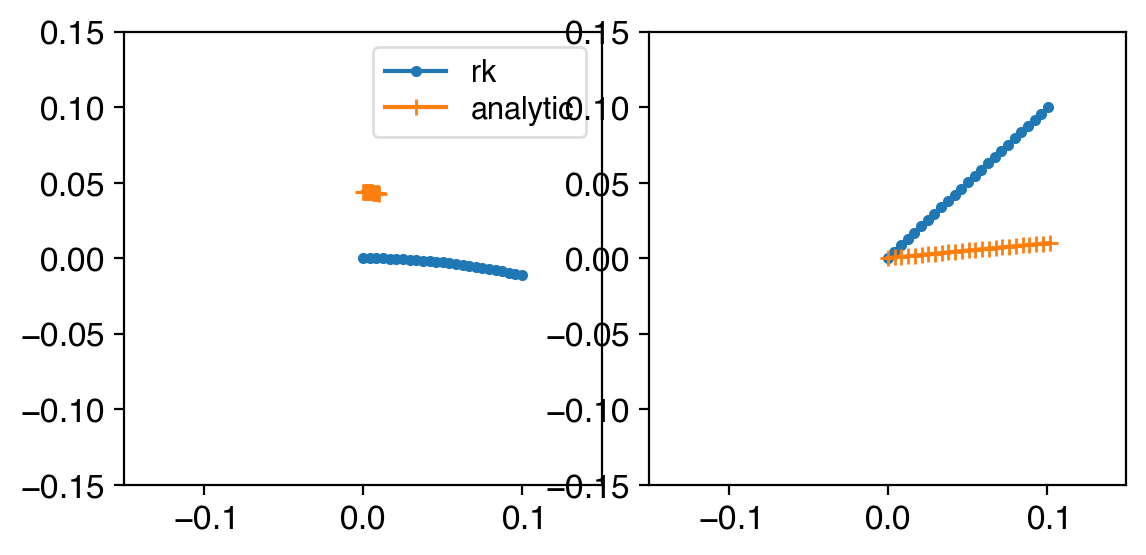